## IMPORTS

In [2]:
import tensorflow as tf
import numpy as np
import cv2 as cv
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

## PIPELINE

In [3]:
class Resizer(BaseEstimator, TransformerMixin):
    def __init__(self,scale_factor=0.5):
        self.scale_factor = scale_factor

    def fit(self, X, y=None):
        return self # nothing to do
    
    def transform(self, X, y=None):
        _,w,h,_ = X.shape
        target_size = (int(w*self.scale_factor),int(h*self.scale_factor))
        return tf.image.resize(X, target_size)

class ImageNormalization(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self # nothing to do
    
    def transform(self, X, y=None):
        return X/255.0


pipe = Pipeline([
        ('resizer',Resizer()),
        ('normalization',ImageNormalization())
    ])

## DATA GENERATOR

In [4]:
IMAGE_SHAPE = (1080, 1920, 3)
PINK_CONTINUES = ((100,20,100),(255,105,180))
PINK_DISCRETE = (255,102,204) 
SEED_RANGE = (0, np.iinfo(np.int32).max)
RANGE_SIZE = {"main":(80,250),"scatter":(5,25)}
NOISE_COLORS = ((0,0,0),(0,0,255),(0,255,00),(255,0,0))
 
    
def generator(samples):
    # defining an empty dataset 
    #w,h,c = IMAGE_SHAPE
    #x_samples = np.zeros(shape=(w,h,c,samples))
    #y_samples = x_samples.copy()    
    # figures and noises attributes
    fig_len,noises_len = len(FIGURES),len(NOISES)
    fig_list,noises_list = list(FIGURES.keys()), list(NOISES.keys())
    for i in range(samples):
        # selecting functions
        figure = FIGURES[fig_list[i % fig_len]]    
        noise = NOISES[noises_list[i % noises_len]]
        # making samples
        #x_samples[:,:,:,i], y_samples[:,:,:,i] = make_sample(figure,noise,PINK_DISCRETE)
        x,y = make_sample(figure,noise,PINK_DISCRETE) 
        save_image(x,"./drive/MyDrive/SNAP_Data/x/"+str(i)+".png")
        save_image(y,"./drive/MyDrive/SNAP_Data/y/"+str(i)+".png")
        if i % 100 == 0 and i != 0:
          print("[{}/{}] Reamining Images: {}".format(i/100,samples/100,samples-i))
        

def make_sample(figure,noise,main_color,background_color=(255,255,255)):
    x = np.zeros(shape=IMAGE_SHAPE) + background_color
    y = x.copy()
    
    # adding figures with main_color to 'x' frame.
    for _ in range(np.random.randint(3,15)):
        x = figure(x,main_color,RANGE_SIZE["main"])

    # adding same frames's noise
    seed = np.random.randint(*SEED_RANGE)
    x = noise(x,seed)
    y = noise(y,seed)
    return x,y


# defining noise functions
def add_scatter_noise(image,seed):
    set_seed(seed)
    for i in range(np.random.randint(10,50)):
        color = NOISE_COLORS[np.random.randint(0,len(NOISE_COLORS))]
        image = add_circle(image,color,RANGE_SIZE["scatter"])
        image = add_rectangle(image,color,RANGE_SIZE["scatter"])
    return image

# defining figure functions
def add_circle(image,color,range_size):
    radius = np.random.randint(*range_size)
    coords = ( np.random.randint(0,IMAGE_SHAPE[1]), np.random.randint(0,IMAGE_SHAPE[0]) )
    return cv.circle(image,coords, radius, color, -1)

def add_rectangle(image,color,range_size):
    x,y = np.random.randint(*range_size,size=2) 
    start_p = ( np.random.randint(0,IMAGE_SHAPE[1]) - x , np.random.randint(0,IMAGE_SHAPE[0]) - y )
    end_p = (start_p[0] + x, start_p[1] + y )
    return cv.rectangle(image, start_p, end_p, color, -1)

def add_mix_figures(image,color,range_size):
    image = add_circle(image,color,range_size)
    image = add_rectangle(image,color,range_size)
    return image

# set numpy random seed
def set_seed(seed):
    np.random.seed(seed if seed else np.random.randint(*SEED_RANGE))

# get a random color `inside` of pink range
def get_inner_color():
    bottom_c, top_c = PINK_CONTINUES 
    r,g,b = [ np.random.randint(bottom_c[i],top_c[i]) for i in range(3) ]
    return (r,g,b)

# get a random color `outside` of pink range
def get_outer_color():
    i = np.random.randint(0,2)
    color_range = PINK_CONTINUES[i]
    color_limit = (i*254, i*254, i*254)
    r,g,b = [ sorted([color_limit[i],color_range[i]]) for i in range(3) ] 
    r,g,b = np.random.randint(*r), np.random.randint(*g), np.random.randint(*b)
    return (r,g,b)

FIGURES = {"rectangle":add_rectangle,
           "circle":add_circle,
           "mix":add_mix_figures}

NOISES = {"nothing":(lambda image,*args,**kwargs: image),
          "scatter":add_scatter_noise}
        

In [61]:
import matplotlib.pyplot as plt
from matplotlib.image import imsave

def show_image(image):
    plt.imshow(image)
    plt.show()

def save_image(image,path_name):
    imsave(path_name, image)

In [6]:
def load_dataset(samples:int):
    x = np.zeros(shape=(samples,*IMAGE_SHAPE))
    y = np.zeros(shape=(samples,*IMAGE_SHAPE))
    for i in range(samples):
        x[i,:,:,:] = cv.imread(f"/content/drive/MyDrive/SNAP_Data/x/{i}.png")
        y[i,:,:,:] = cv.imread(f"/content/drive/MyDrive/SNAP_Data/y/{i}.png")

    # splitting train set
    x_train = x[:int((len(x))*0.9)]
    y_train = y[:int((len(y))*0.9)]
    # splitting test set
    x_test = x[int((len(x))*0.9):]
    y_test = y[int((len(y))*0.9):]
    return (x_train,y_train),(x_test,y_test)

## MODEL ARCHITECTURE DEFINITION

In [108]:
class CAE(tf.keras.Model):
    """Convolutional variational autoencoder."""
    def __init__(self):
        super(CAE, self).__init__()
        self.encoder = tf.keras.Sequential([
                tf.keras.layers.Input(shape=(540, 960, 3)),
                tf.keras.layers.Conv2D( 
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu',padding='same'),
                #tf.keras.layers.MaxPooling2D(padding='same'),
                #tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu',padding='same'),
                #tf.keras.layers.MaxPooling2D(padding='same'),
                #tf.keras.layers.BatchNormalization(),
                ])
        
        self.decoder = tf.keras.Sequential([
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=3, kernel_size=3, strides=1, padding='same'),
                ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = CAE()
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

## Gathering & fixing data

In [122]:
(x_train,y_train),(x_test,y_test) = load_dataset(30)
x_train = pipe.fit_transform(x_train)
y_train = pipe.transform(y_train)
x_test = pipe.transform(x_test)
y_test = pipe.transform(y_test)

## Training model

In [120]:
autoencoder.fit(x_train,y_train,
                epochs=50,
                shuffle=True,
                validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 8.8235e-04 - val_loss: 0.0011
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 8.8104e-04 - val_loss: 0.0011
Epoch 3/50
1/1 [==============================] - 1s 1s/step - loss: 8.8172e-04 - val_loss: 0.0011
Epoch 4/50
1/1 [==============================] - 1s 1s/step - loss: 8.7854e-04 - val_loss: 0.0011
Epoch 5/50
1/1 [==============================] - 1s 1s/step - loss: 8.7078e-04 - val_loss: 0.0011
Epoch 6/50
1/1 [==============================] - 1s 1s/step - loss: 8.6403e-04 - val_loss: 0.0011
Epoch 7/50
1/1 [==============================] - 1s 1s/step - loss: 8.6043e-04 - val_loss: 0.0011
Epoch 8/50
1/1 [==============================] - 1s 1s/step - loss: 8.5906e-04 - val_loss: 0.0011
Epoch 9/50
1/1 [==============================] - 1s 1s/step - loss: 8.5745e-04 - val_loss: 0.0011
Epoch 10/50
1/1 [==============================] - 1s 1s/step - loss: 8.5352e-04 - val_loss: 0.0011
Epoch 11/

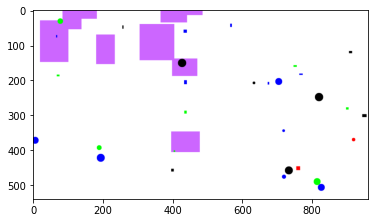

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


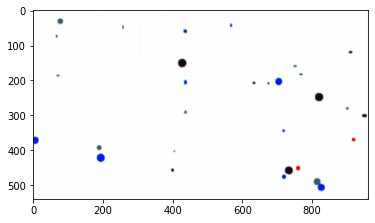

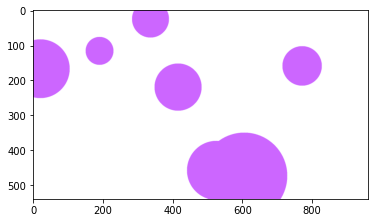

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


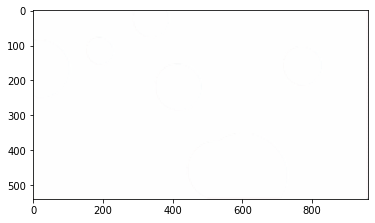

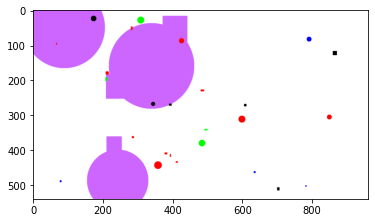

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


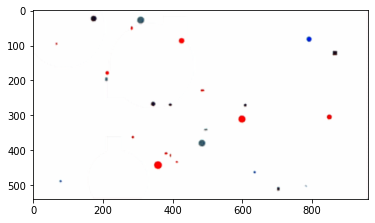

In [130]:
y_pred = autoencoder.predict(x_test)
for i in range(y_pred.shape[0]):
  show_image(x_test[i,:,:,:])
  show_image(y_pred[i,:,:,:])